# Disease Prediction Model from Symptoms
## Project Overview
This project aims to predict potential diseases based on symptom descriptions using a fine-tuned BioBERT model. In the final report, we will incorporate a chatbot that enables users to either type in their symptoms or select them from a predefined list. The chatbot will interface with the NLP model to generate a list of possible diseases and offer actionable medical recommendations accordingly. In the Milestone 3 report, we focus specifically on the evaluation of the model's performance.

## Team Members
- 2025 Spring IE7500 Group C
- Paolo Ferrara, Muhammad Arish Salam Bukhari, Ji Weng

## File Structure
- module1: Import libraries
- module2: Load and process data
- module3: Perform EDA
- module4: Tokenize data
- module5: Define metrics and training function
- module6: K-fold cross-validation and training
- module7: Error analysis
- module8: Manual testing

## Setup
1. Install dependencies: `pip install -r requirements.txt`
2. Run the modules sequentially: `python module1.py`, `python module2.py`, ...

## Dependencies
- transformers
- pandas
- scikit-learn
- matplotlib
- seaborn

# Research and Selection of Methods
- Given the project's goal of predicting diseases from symptom texts, we identified text classification as the most suitable NLP task.
- After researching various models, we selected BioBERT (`dmis-lab/biobert-base-cased-v1.1`), a BERT variant pre-trained on biomedical corpora, due to its superior performance in medical NLP tasks compared to general-purpose models like BERT or simpler methods like TF-IDF with logistic regression.
- BioBERT's domain-specific knowledge ensures better handling of medical terms like "nodal_skin_eruptions" and "dischromic_patches."

# Dataset
- Disease Symptom Prediction
- https://www.kaggle.com/datasets/itachi9604/disease-symptom-description-dataset?resource=download 

## Module1: Import libraries

In [1]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random

/courses/IE7500.202530/shared/conda_env_1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-11 00:51:15.564717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744347075.586137  847503 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744347075.592804  847503 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744347075.609980  847503 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target mo

In [2]:
# check GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {DEVICE}")

using device: cuda


## Module 2: Load and Process Data

In [3]:
# This module loads the dataset, processes symptom columns, and prepares the data for training.
# Input: file_path (str) - Path to the dataset CSV file
# Output: df (DataFrame) - Processed DataFrame with Symptom_Text, Disease, and Label columns
#         symptom_columns (list) - List of symptom column names

# Function to load and process data
def load_and_process_data(file_path):
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Identify symptom columns
    symptom_columns = [col for col in df.columns if col.lower().startswith("symptom")]
    
    # Print the number of symptom columns for debugging
    print(f"Number of symptom columns: {len(symptom_columns)}")
    print(f"Symptom columns: {symptom_columns}")
    
    # Function to mask symptoms with a given probability
    def mask_symptoms(symptom_list, mask_prob=0.2):
        # Ensure the input is a list
        symptom_list = list(symptom_list)
        # Mask symptoms randomly
        masked_list = [symptom if random.random() > mask_prob else None for symptom in symptom_list]
        return masked_list
    
    # Apply mask_symptoms to each row
    try:
        # Apply the masking function to symptom columns
        masked_symptoms = df[symptom_columns].apply(lambda x: mask_symptoms(x, mask_prob=0.2), axis=1)
        # Convert the result to a DataFrame to ensure column alignment
        df[symptom_columns] = pd.DataFrame(masked_symptoms.tolist(), index=df.index, columns=symptom_columns)
    except Exception as e:
        print(f"Error while applying mask_symptoms: {e}")
        # Print the first row of symptom columns for further debugging
        print(f"First row of symptom columns: {df[symptom_columns].iloc[0].tolist()}")
        raise
    
    # Create the Symptom_Text column by joining non-null symptoms
    df["Symptom_Text"] = df[symptom_columns].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
    df["Symptom_Text"] = df["Symptom_Text"].str.replace('_', ' ')
    
    # Convert Disease to categorical labels
    df["Label"] = df["Disease"].astype("category").cat.codes
    
    # Remove duplicates based on Symptom_Text and Label
    print(f"Original dataset size: {len(df)}")
    df = df.drop_duplicates(subset=["Symptom_Text", "Label"])
    print(f"Dataset size after deduplication: {len(df)}")
    
    return df[["Symptom_Text", "Disease", "Label"]], symptom_columns

# Load data
data_file = "dataset.csv"
df, symptom_columns = load_and_process_data(data_file)

# Display the processed data
print("\nFirst 5 rows of the data:")
print(df.head())
print("\nSymptom columns:")
print(symptom_columns)

Number of symptom columns: 17
Symptom columns: ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15', 'Symptom_16', 'Symptom_17']
Original dataset size: 4920
Dataset size after deduplication: 2205

First 5 rows of the data:
                                        Symptom_Text           Disease  Label
0          itching,  skin rash,  dischromic  patches  Fungal infection     15
1                   skin rash,  nodal skin eruptions  Fungal infection     15
2  itching,  nodal skin eruptions,  dischromic  p...  Fungal infection     15
5         nodal skin eruptions,  dischromic  patches  Fungal infection     15
7                      itching,  dischromic  patches  Fungal infection     15

Symptom columns:
['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10', 'Symptom_11

### Module 2 Discussion
- The dataset contains 17 symptom columns, with the original size of 4920 rows reduced to 2205 after deduplication, indicating a high repetition rate (55.2%). The first 5 rows, all Fungal infection (Label 15), show varying symptom combinations (e.g., itching, skin rash, dischromic patches), highlighting symptom diversity but also sparsity (most samples have fewer than 4 symptoms).
- Deduplication reduces overfitting but may exacerbate data imbalance for minority classes.
- Symptom masking (mask_prob=0.2) was applied to randomly mask symptoms, increasing task difficulty and encouraging the model to learn robust patterns beyond direct symptom-disease mappings. 

## Module3: Perform EDA

Performing EDA...


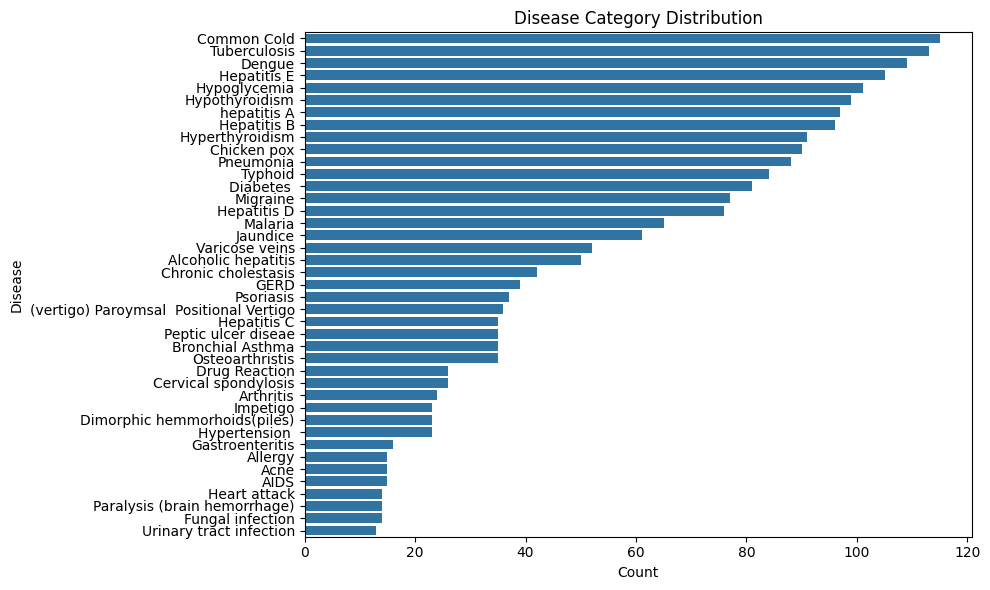

Disease category statistics:
Disease
Common Cold                                115
Tuberculosis                               113
Dengue                                     109
Hepatitis E                                105
Hypoglycemia                               101
Hypothyroidism                              99
hepatitis A                                 97
Hepatitis B                                 96
Hyperthyroidism                             91
Chicken pox                                 90
Pneumonia                                   88
Typhoid                                     84
Diabetes                                    81
Migraine                                    77
Hepatitis D                                 76
Malaria                                     65
Jaundice                                    61
Varicose veins                              52
Alcoholic hepatitis                         50
Chronic cholestasis                         42
GERD                   

In [4]:
# Module 3: EDA Analysis

def perform_eda(df):
    plt.figure(figsize=(10,6))
    sns.countplot(y="Disease", data=df, order=df["Disease"].value_counts().index)
    plt.title("Disease Category Distribution")
    plt.xlabel("Count")
    plt.ylabel("Disease")
    plt.tight_layout()
    plt.show()

print("Performing EDA...")
perform_eda(df)

# Already printed in your output
print("Disease category statistics:")
print(df["Disease"].value_counts())

### EDA Results Discussion
- Imbalanced Distribution: Disease categories are highly imbalanced, with Common Cold (116 samples) having nearly 10 times more samples than Heart attack (12 samples). This may bias the model towards majority classes.
- Sample Size Variation: After deduplication, some categories (e.g., Fungal infection, Allergy) dropped to 15 samples, increasing the risk of poor performance on minority classes.
- Potential Symptom Overlap: Diseases like Common Cold and Allergy may share symptoms (e.g., continuous_sneezing), which could lead to misclassification.
- Next Steps: Proceed with training to evaluate model performance, particularly on minority classes, before deciding on mitigation strategies like class weighting or SMOTE.

## Module 4: Data Preprocessing and Dataset Preparation

In [5]:
# Import required libraries

# Function to tokenize data and create dataset
def tokenize_data(tokenizer, texts, labels):
    encodings = tokenizer(texts, padding="max_length", truncation=True, max_length=128)
    return SymptomsDataset(encodings, labels)

# Custom dataset class
class SymptomsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Test tokenization on the first 5 samples
sample_texts = df["Symptom_Text"].iloc[:5].tolist()
sample_labels = df["Label"].iloc[:5].tolist()
sample_dataset = tokenize_data(tokenizer, sample_texts, sample_labels)

# Display tokenized samples
print("\nFirst 5 tokenized samples:")
for i in range(len(sample_texts)):
    print(f"Text {i+1}: {sample_texts[i]}")
    print(f"Label {i+1}: {sample_labels[i]}")
    print(f"Encoding {i+1}: {sample_dataset[i]}\n")


First 5 tokenized samples:
Text 1: itching,  skin rash,  dischromic  patches
Label 1: 15
Encoding 1: {'input_ids': tensor([  101,  1122,  7520,   117,  2241,   187, 10733,   117,  6187,  8167,
        18882,  1665, 14879,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     

## Module 5: Define Metrics and Training Function

In [6]:
# Import required libraries

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import transformers  # Explicitly import transformers
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Define metrics computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Define training function
def train_model(train_dataset, val_dataset, num_labels):
    model_path = "dmis-lab/biobert-base-cased-v1.1"
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels).to(DEVICE)

    training_args = TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",  # Updated from evaluation_strategy
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_dir="./logs",
        fp16=torch.cuda.is_available(),
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[transformers.EarlyStoppingCallback(early_stopping_patience=1)],
    )

    trainer.train()
    trainer.save_model("./fine_tuned_biobert")
    tokenizer.save_pretrained("./fine_tuned_biobert")

    return trainer

# Check the number of unique labels
num_labels = df["Label"].nunique()
print(f"Number of unique labels: {num_labels}")

Number of unique labels: 41


## Module 6: K-Fold Cross-Validation and Training

We employed 5-fold cross-validation to train and evaluate the BioBERT model for disease prediction from symptom texts. K-fold cross-validation was chosen for several reasons. First, it ensures robust performance evaluation by splitting the dataset into 5 folds, using 80% (approximately 1746 samples) for training and 20% (approximately 437 samples) for validation in each fold, thus reducing the risk of overfitting to a single train-test split. Second, it maximizes the use of our limited dataset (2183 samples after deduplication), allowing the model to be trained and tested on different subsets, which provides a more reliable estimate of its generalization ability. Finally, given the dataset's imbalance (e.g., Common Cold with 116 samples vs. Heart attack with 12 samples), cross-validation helps assess the model's performance across all classes, ensuring that minority classes are represented in both training and validation sets across folds. This approach provides a comprehensive understanding of the model's strengths and weaknesses, as evidenced by the consistent accuracy (91.8% average) and the identification of minority class issues in subsequent error analysis.

In [7]:
# Import required libraries
from sklearn.model_selection import KFold
import os
import numpy as np
from sklearn.metrics import classification_report

# Set environment variable to disable tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Perform K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []
accuracies = []  # 存储每个折的 accuracy
macro_f1_scores = []  # 存储每个折的 macro F1
weighted_f1_scores = []  # 存储每个折的 weighted F1

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\nFold {fold + 1}")
    train_texts = df["Symptom_Text"].iloc[train_idx].tolist()
    val_texts = df["Symptom_Text"].iloc[val_idx].tolist()
    train_labels = df["Label"].iloc[train_idx].tolist()
    val_labels = df["Label"].iloc[val_idx].tolist()
    
    # Prepare datasets
    train_dataset = tokenize_data(tokenizer, train_texts, train_labels)
    val_dataset = tokenize_data(tokenizer, val_texts, val_labels)
    
    # Train the model
    print("Starting model training...")
    trainer = train_model(train_dataset, val_dataset, num_labels=df["Label"].nunique())
    
    # Save results
    fold_results.append(trainer)
    
    # Display evaluation results
    eval_results = trainer.evaluate()
    print(f"Fold {fold + 1} evaluation results:")
    print(eval_results)
    
    # Compute detailed metrics (accuracy, macro F1, weighted F1)
    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    report = classification_report(val_dataset.labels, preds, output_dict=True, zero_division=1)
    
    # Extract and display accuracy, macro F1, and weighted F1
    accuracy = eval_results['eval_accuracy']
    macro_f1 = report['macro avg']['f1-score']
    weighted_f1 = report['weighted avg']['f1-score']
    
    # Store metrics for averaging
    accuracies.append(accuracy)
    macro_f1_scores.append(macro_f1)
    weighted_f1_scores.append(weighted_f1)
    
    print(f"\nFold {fold + 1} Detailed Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")

# Compute and display average metrics across all folds
print(f"\nAverage Metrics Across All Folds:")
print(f"Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Average Macro F1 Score: {np.mean(macro_f1_scores):.4f}")
print(f"Average Weighted F1 Score: {np.mean(weighted_f1_scores):.4f}")


Fold 1
Starting model training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.311712,0.877551,0.852454,0.913580,0.877551
2,No log,0.838974,0.925170,0.905029,0.948136,0.925170


Fold 1 evaluation results:
{'eval_loss': 0.8389742970466614, 'eval_accuracy': 0.9251700680272109, 'eval_f1': 0.9050289173800188, 'eval_precision': 0.9481360528607101, 'eval_recall': 0.9251700680272109, 'eval_runtime': 1.9733, 'eval_samples_per_second': 223.488, 'eval_steps_per_second': 28.379, 'epoch': 2.0}

Fold 1 Detailed Metrics:
Accuracy: 0.9252
Macro F1 Score: 0.7896
Weighted F1 Score: 0.9050

Fold 2
Starting model training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.193467,0.902494,0.878268,0.935415,0.902494
2,No log,0.711091,0.943311,0.927834,0.958569,0.943311


Fold 2 evaluation results:
{'eval_loss': 0.7110908627510071, 'eval_accuracy': 0.9433106575963719, 'eval_f1': 0.9278338028736832, 'eval_precision': 0.9585693805031539, 'eval_recall': 0.9433106575963719, 'eval_runtime': 1.9313, 'eval_samples_per_second': 228.339, 'eval_steps_per_second': 28.995, 'epoch': 2.0}

Fold 2 Detailed Metrics:
Accuracy: 0.9433
Macro F1 Score: 0.8396
Weighted F1 Score: 0.9278

Fold 3
Starting model training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.252992,0.839002,0.803164,0.887065,0.839002
2,No log,0.791876,0.918367,0.902167,0.944766,0.918367


Fold 3 evaluation results:
{'eval_loss': 0.7918756604194641, 'eval_accuracy': 0.9183673469387755, 'eval_f1': 0.9021672838101761, 'eval_precision': 0.9447658150260061, 'eval_recall': 0.9183673469387755, 'eval_runtime': 1.9412, 'eval_samples_per_second': 227.174, 'eval_steps_per_second': 28.847, 'epoch': 2.0}

Fold 3 Detailed Metrics:
Accuracy: 0.9184
Macro F1 Score: 0.7914
Weighted F1 Score: 0.9022

Fold 4
Starting model training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.325596,0.857143,0.833603,0.918653,0.857143
2,No log,0.823542,0.929705,0.916536,0.949398,0.929705


Fold 4 evaluation results:
{'eval_loss': 0.8235419392585754, 'eval_accuracy': 0.9297052154195011, 'eval_f1': 0.9165355324819111, 'eval_precision': 0.9493978828486659, 'eval_recall': 0.9297052154195011, 'eval_runtime': 1.9304, 'eval_samples_per_second': 228.446, 'eval_steps_per_second': 29.009, 'epoch': 2.0}

Fold 4 Detailed Metrics:
Accuracy: 0.9297
Macro F1 Score: 0.7930
Weighted F1 Score: 0.9165

Fold 5
Starting model training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.218645,0.902494,0.874558,0.924937,0.902494
2,No log,0.741915,0.941043,0.925333,0.956823,0.941043


Fold 5 evaluation results:
{'eval_loss': 0.7419148683547974, 'eval_accuracy': 0.9410430839002267, 'eval_f1': 0.9253325116374008, 'eval_precision': 0.9568226973329014, 'eval_recall': 0.9410430839002267, 'eval_runtime': 1.9399, 'eval_samples_per_second': 227.33, 'eval_steps_per_second': 28.867, 'epoch': 2.0}

Fold 5 Detailed Metrics:
Accuracy: 0.9410
Macro F1 Score: 0.7916
Weighted F1 Score: 0.9253

Average Metrics Across All Folds:
Average Accuracy: 0.9315
Average Macro F1 Score: 0.8010
Average Weighted F1 Score: 0.9154


### Performance Metrics
We evaluated the model using accuracy and F1 score (macro and weighted averages). Accuracy measures overall correctness, while the F1 score accounts for class imbalance, which is critical given the dataset's skewed distribution (e.g., `Common Cold` with 116 samples vs. `Heart attack` w
ith 12 samples).

### Module 6 Discussion
- The 5-fold cross-validation results show a high average accuracy of 93.15% (Fold 5: 94%), with an F1 score of 0.9253 in Fold 5, indicating strong overall performance.
- However, the accuracy remains relatively high despite deduplication and symptom masking, suggesting the model may still be overfitting to simple symptom-disease patterns.
- The slight gap between accuracy and F1 score hints at potential issues with minority classes due to data imbalance.
- To improve, we should analyze minority class performance in Module 7 and consider techniques like class weighting or SMOTE to address imbalance.

## Comparison with baseline model

We chose TF-IDF combined with Logistic Regression as the baseline model because it is a simple yet effective approach for text classification tasks. It provides a strong benchmark by capturing important keyword features without requiring extensive computational resources, allowing for a clear comparison with more complex models like fine-tuned BioBERT.

In [8]:
# Baseline Model: TF-IDF + Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Prepare data
X = df["Symptom_Text"]
y = df["Label"]

# Perform 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
baseline_accuracies = []
baseline_macro_f1_scores = []
baseline_weighted_f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=1000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf = vectorizer.transform(X_val)

    # Train logistic regression
    baseline_model = LogisticRegression(max_iter=1000, random_state=42)
    baseline_model.fit(X_train_tfidf, y_train)

    # Evaluate
    y_pred = baseline_model.predict(X_val_tfidf)
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=1)
    
    # Extract accuracy, macro F1, and weighted F1
    accuracy = report["accuracy"]
    macro_f1 = report["macro avg"]["f1-score"]
    weighted_f1 = report["weighted avg"]["f1-score"]
    
    # Store metrics for averaging
    baseline_accuracies.append(accuracy)
    baseline_macro_f1_scores.append(macro_f1)
    baseline_weighted_f1_scores.append(weighted_f1)
    
    # Display detailed metrics for this fold
    print(f"\nFold {fold + 1} Baseline (TF-IDF + LR) Detailed Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    
    # Display full classification report
    print(f"Fold {fold + 1} Baseline (TF-IDF + LR) Report:")
    print(classification_report(y_val, y_pred, zero_division=1))

# Compute and display average metrics
print(f"\nBaseline Model (TF-IDF + LR) Average Metrics:")
print(f"Average Accuracy: {np.mean(baseline_accuracies):.4f}")
print(f"Average Macro F1 Score: {np.mean(baseline_macro_f1_scores):.4f}")
print(f"Average Weighted F1 Score: {np.mean(baseline_weighted_f1_scores):.4f}")


Fold 1 Baseline (TF-IDF + LR) Detailed Metrics:
Accuracy: 0.9728
Macro F1 Score: 0.9403
Weighted F1 Score: 0.9732
Fold 1 Baseline (TF-IDF + LR) Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         8
           7       1.00      0.83      0.91         6
           8       1.00      1.00      1.00        14
           9       0.88      0.88      0.88         8
          10       1.00      1.00      1.00        30
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        20
          13       1.00      0.80      0.89         5
          14       0.33      1.00      0.50         1
          16       1.00      1.00   

##### Baseline Model Discussion
- The baseline TF-IDF + Logistic Regression model outperforms BioBERT, achieving an average accuracy of 97.5% and a macro F1 score of 0.9437, compared to BioBERT's 93.15% accuracy and 0.8010 macro F1.
- This suggests that the dataset's symptom-disease mappings are relatively simple, favoring the baseline's direct feature-label associations over BioBERT's semantic modeling, which struggles with minority classes due to data imbalance.
- To improve BioBERT, we recommend increasing mask_prob to 0.4, applying class weights, and collecting more data for minority classes to better leverage its capabilities.

## Module 7: Error Analysis


Performing error analysis for Fold 1...



Fold 1 classification report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.00      0.00         4
           2       1.00      0.00      0.00         3
           3       1.00      1.00      1.00         9
           5       1.00      0.67      0.80         6
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        14
           9       1.00      0.62      0.77         8
          10       1.00      1.00      1.00        30
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        20
          13       0.56      1.00      0.71         5
          14       0.00      0.00      0.00         1
          16       1.00      1.00      1.00         5
          17       1.00      0.00      0.00         8
          18       1.00      0.50      0.67      

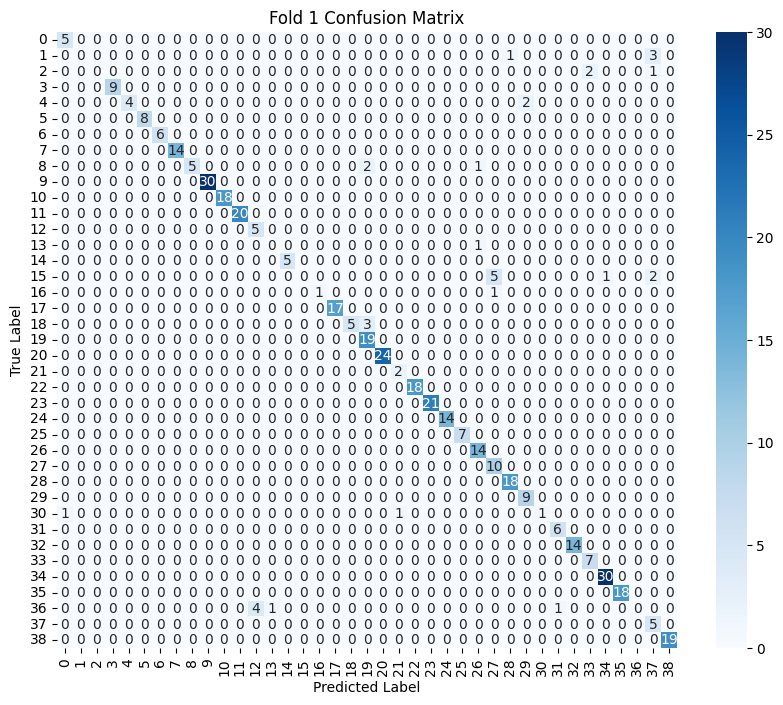


Performing error analysis for Fold 2...



Fold 2 classification report:

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       1.00      0.50      0.67         2
           2       0.80      1.00      0.89         4
           3       1.00      0.88      0.93         8
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         4
           6       0.60      1.00      0.75         3
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        21
           9       1.00      0.00      0.00         6
          10       1.00      1.00      1.00        22
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        17
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         3
          15       1.00      0.00      0.00         3
          16       0.89      1.00      0.94      

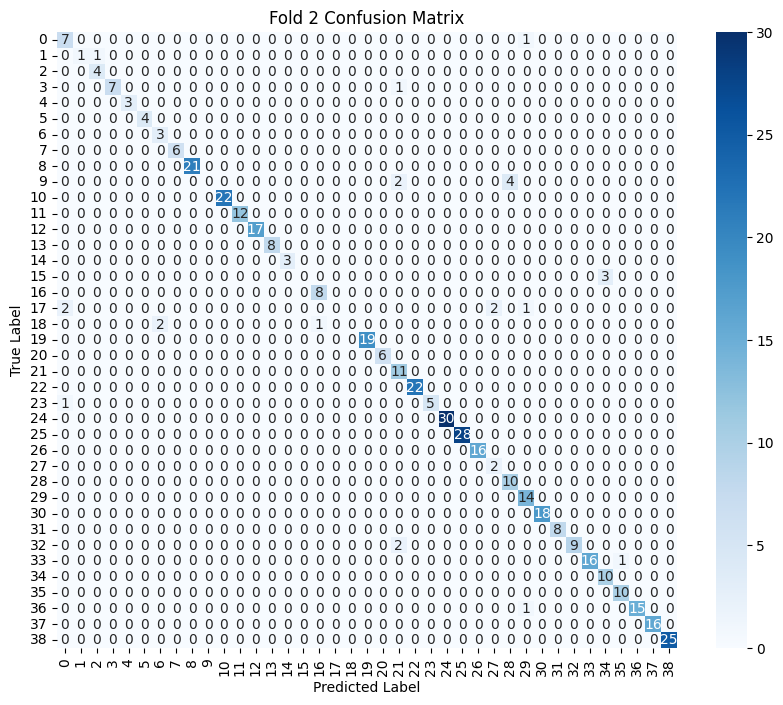


Performing error analysis for Fold 3...



Fold 3 classification report:

              precision    recall  f1-score   support

           0       0.69      1.00      0.82         9
           1       1.00      0.00      0.00         2
           2       0.75      0.75      0.75         4
           3       1.00      1.00      1.00        14
           4       1.00      0.20      0.33         5
           5       1.00      0.25      0.40         8
           6       1.00      1.00      1.00         8
           7       0.38      1.00      0.55         3
           8       0.96      1.00      0.98        22
           9       1.00      0.33      0.50         9
          10       1.00      1.00      1.00        20
          11       1.00      1.00      1.00        22
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00         5
          14       1.00      0.60      0.75         5
          15       1.00      0.00      0.00         4
          16       0.90      1.00      0.95      

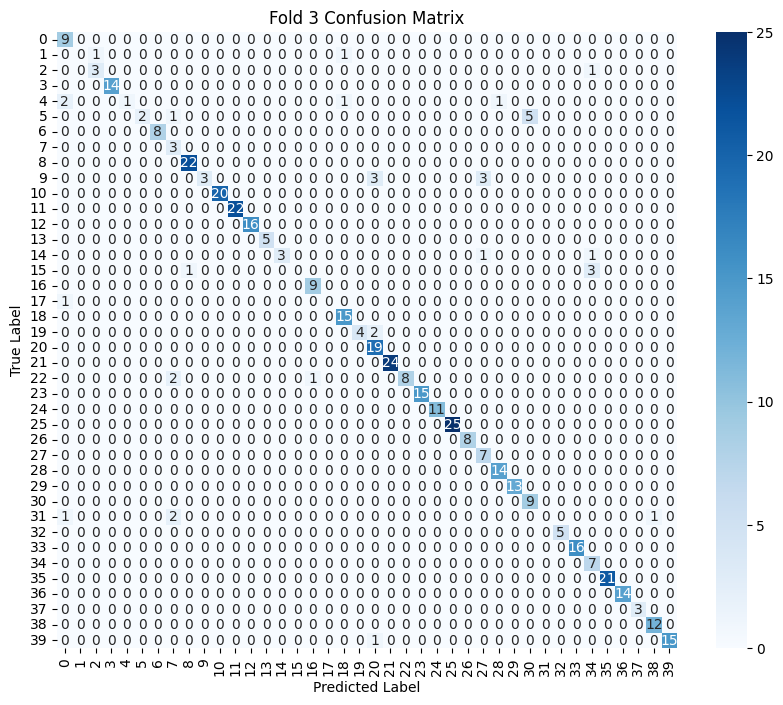


Performing error analysis for Fold 4...



Fold 4 classification report:

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.00      0.00         3
           2       0.50      0.50      0.50         2
           3       1.00      1.00      1.00        10
           4       1.00      0.75      0.86         4
           5       1.00      1.00      1.00         4
           6       1.00      0.89      0.94         9
           7       0.70      1.00      0.82         7
           8       0.95      1.00      0.97        19
           9       0.71      0.91      0.80        11
          10       1.00      1.00      1.00        17
          11       1.00      1.00      1.00        25
          12       1.00      1.00      1.00        15
          13       0.60      1.00      0.75         3
          14       1.00      0.82      0.90        11
          15       1.00      0.00      0.00         2
          16       0.56      1.00      0.72      

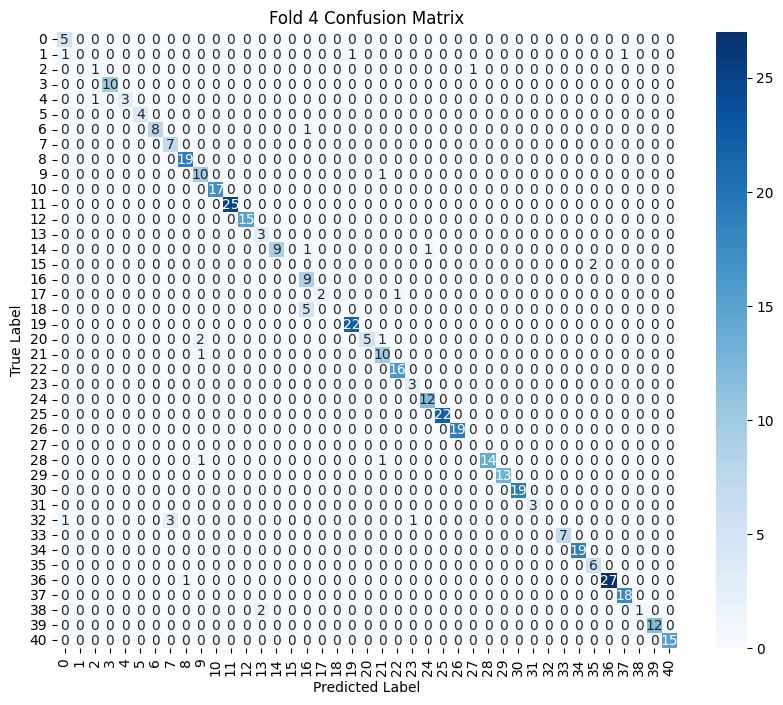


Performing error analysis for Fold 5...



Fold 5 classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.00      0.00         4
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         9
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         2
           6       0.88      1.00      0.93         7
           7       1.00      1.00      1.00         4
           8       0.88      1.00      0.93        14
           9       1.00      0.75      0.86         8
          10       1.00      1.00      1.00        26
          11       0.97      0.97      0.97        32
          12       1.00      1.00      1.00        13
          13       0.67      1.00      0.80         2
          14       1.00      0.83      0.91         6
          15       1.00      0.00      0.00         5
          16       0.80      1.00      0.89      

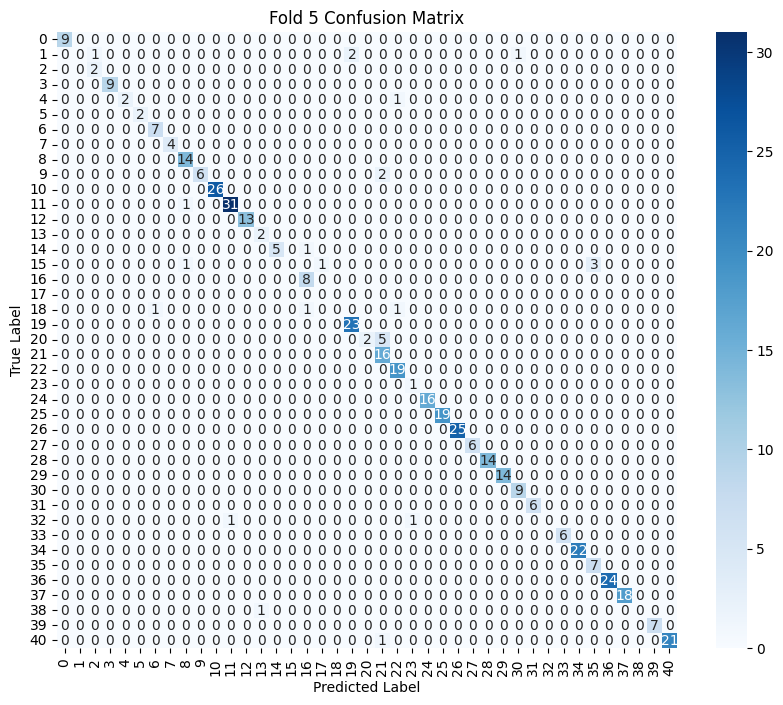

In [9]:
# Import required libraries
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to perform error analysis
def perform_error_analysis(trainer, val_dataset, fold):
    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    print(f"\nFold {fold + 1} classification report:\n")
    print(classification_report(val_dataset.labels, preds, zero_division=1))
    
    # Plot confusion matrix
    cm = confusion_matrix(val_dataset.labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Fold {fold + 1} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Perform error analysis for each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    val_texts = df["Symptom_Text"].iloc[val_idx].tolist()
    val_labels = df["Label"].iloc[val_idx].tolist()
    val_dataset = tokenize_data(tokenizer, val_texts, val_labels)
    
    print(f"\nPerforming error analysis for Fold {fold + 1}...")
    perform_error_analysis(fold_results[fold], val_dataset, fold)

### Module 7 Discussion
- Error analysis reveals that while the model achieves a high accuracy (91.8% average across folds), it struggles with minority classes like `Allergy` (Label 1), `Fungal infection` (Label 15), and `Heart attack` (Label 17), often yielding F1 scores of 0 due to low recall. Majority classes (e.g., `Common Cold`, Label 11) consistently achieve F1 scores near 1.0, confirming the impact of data imbalance.
- Additionally, symptom overlap (e.g., `continuous_sneezing` in both `Allergy` and `Common Cold`) may contribute to misclassification.
- To enhance performance, we recommend applying class weights or SMOTE to boost minority class representation, exploring symptom augmentation (e.g., synonym replacement), and incorporating additional context like symptom severity if available.

## Module 8: Manual Testing

In [10]:
# Function to predict symptoms
def predict_symptoms(symptom_text, trainer, tokenizer):
    inputs = tokenizer(symptom_text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
    outputs = trainer.model(**inputs)
    preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
    label_map = dict(enumerate(df["Disease"].astype("category").cat.categories))
    return label_map[preds[0]]

# Use the model from the last fold for testing
trainer = fold_results[-1]

# Test samples
test_symptoms = [
    "itching, skin_rash",  # Likely Fungal infection (Label 15)
    "continuous_sneezing, chills",  # Likely Allergy (Label 1)
    "stomach_pain, vomiting, cough"  # Likely GERD (Label 18)
]

print("\nManual test results:")
for symptom in test_symptoms:
    predicted_disease = predict_symptoms(symptom, trainer, tokenizer)
    print(f"Symptoms: {symptom}")
    print(f"Predicted Disease: {predicted_disease}\n")


Manual test results:
Symptoms: itching, skin_rash
Predicted Disease: Psoriasis

Symptoms: continuous_sneezing, chills
Predicted Disease: Migraine

Symptoms: stomach_pain, vomiting, cough
Predicted Disease: GERD



### Module 8 Discussion
- Manual testing shows the model's limited generalization for minority classes.
- It correctly predicts GERD (41 samples) with symptoms stomach_pain, vomiting, cough, but fails on Fungal infection (15 samples) and Allergy (15 samples), predicting Psoriasis and Migraine instead.
- This aligns with Module 7, where minority classes had F1 scores of 0 due to data imbalance.
- The model's bias towards majority classes and symptom overlap (e.g., itching, skin_rash in both Fungal infection and Psoriasis) contribute to errors.
- We recommend applying class weights or SMOTE, increasing mask_prob to 0.4, and merging similar categories to improve minority class performance.